In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from lightgbm import early_stopping

import warnings
warnings.filterwarnings('ignore')

In [44]:
df = pd.read_csv("intro_extro.csv")
df

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...,...
18519,18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert
18522,18522,NaN,Yes,1.0,0.0,Yes,5.0,2.0,Introvert


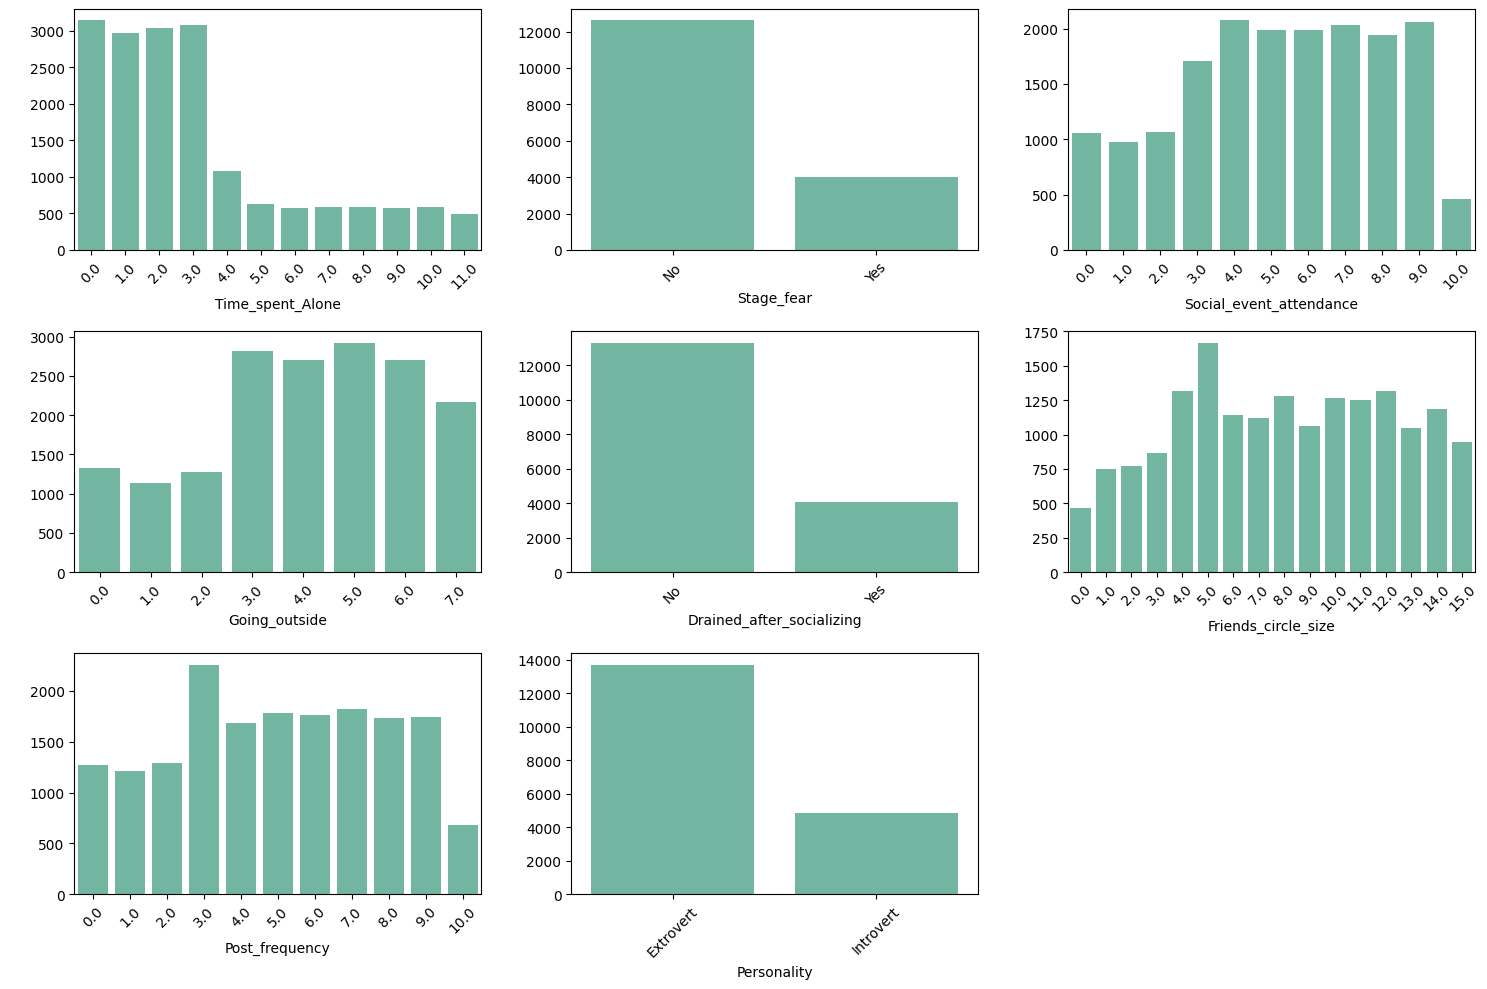

In [45]:
features = df.drop('id', axis = 1).columns.tolist()

sns.set_palette('Set2')
plt.figure(figsize=(15, 10))

# Loop through and plot each histogram
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    ax = sns.countplot(x=col, data=df)
    
    plt.xlabel(col)
    plt.ylabel(' ')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

In [46]:
df.isna().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [48]:

# Impute categorical (object/dtype) columns with mode
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Impute continuous (numerical) columns with median
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

In [49]:
df.isna().sum()

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           18524 non-null  float64
 2   Stage_fear                 18524 non-null  object 
 3   Social_event_attendance    18524 non-null  float64
 4   Going_outside              18524 non-null  float64
 5   Drained_after_socializing  18524 non-null  object 
 6   Friends_circle_size        18524 non-null  float64
 7   Post_frequency             18524 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [51]:
df['Stage_fear'].value_counts()

Stage_fear
No     14502
Yes     4022
Name: count, dtype: int64

In [52]:
df['Drained_after_socializing'].value_counts()

Drained_after_socializing
No     14462
Yes     4062
Name: count, dtype: int64

In [53]:
df['Personality'].value_counts()

Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64

In [54]:
df['Stage_fear'] = df['Stage_fear'].map({'Yes': 1, 'No': 0})
df['Drained_after_socializing'] = df['Drained_after_socializing'].map({'Yes': 1, 'No': 0})
df['Personality'] = df['Personality'].map({'Extrovert': 1, 'Introvert': 0})

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           18524 non-null  float64
 2   Stage_fear                 18524 non-null  int64  
 3   Social_event_attendance    18524 non-null  float64
 4   Going_outside              18524 non-null  float64
 5   Drained_after_socializing  18524 non-null  int64  
 6   Friends_circle_size        18524 non-null  float64
 7   Post_frequency             18524 non-null  float64
 8   Personality                18524 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 1.3 MB


In [56]:
# Split
X = df.drop(["id", "Personality"], axis=1)
y = df["Personality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train model
lgb_model = LGBMClassifier(
    n_estimators=98, max_depth=12, learning_rate=0.1,
    reg_lambda=1.15, subsample=0.95, colsample_bytree=1, random_state=43
)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 10280, number of negative: 3613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 13893, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.739941 -> initscore=1.045662
[LightGBM] [Info] Start training from score 1.045662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMClassifier(colsample_bytree=1, max_depth=12, n_estimators=98,
               random_state=43, reg_lambda=1.15, subsample=0.95)

In [57]:
y_pred = lgb_model.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred, y_test))
      

[[1125   64]
 [  87 3355]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1189
           1       0.98      0.97      0.98      3442

    accuracy                           0.97      4631
   macro avg       0.95      0.96      0.96      4631
weighted avg       0.97      0.97      0.97      4631



In [ ]:
# Convert X to float numpy array (ensure shape compatibility)
X_np = X_train.astype(np.float32).to_numpy()
X_np

array([[ 2.,  0.,  4., ...,  0.,  6.,  5.],
       [ 4.,  1.,  3., ...,  1.,  2.,  3.],
       [ 2.,  0.,  8., ...,  0., 15.,  8.],
       ...,
       [ 3.,  0.,  7., ...,  0., 14.,  8.],
       [ 3.,  0.,  4., ...,  0.,  9.,  9.],
       [ 0.,  0.,  3., ...,  0., 14.,  6.]], dtype=float32)

In [62]:
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

# Define the input type
initial_type = [('input', FloatTensorType([None, X_np.shape[1]]))]

# Convert LightGBM model to ONNX
onnx_model = onnxmltools.convert_lightgbm(lgb_model, initial_types=initial_type)

# Save to file
with open("lgb_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
